In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, roc_curve
from xgboost import XGBClassifier


file_path = "Quality_of_Life.csv"
df = pd.read_csv(file_path)

# Veri setinin özet bilgisi
print("\nVeri seti bilgisi:")
print(df.info())

# Eksik veri kontrolü
print("\nEksik veri kontrolü:")
print(df.isnull().sum())
# Eksik değerlerin doldurulması
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)

# Hedef değişken seçimi (örnek olarak 'Quality of Life Category' kullanıyoruz)
target = "Quality of Life Category"
label_encoders = {}

# Kategorik verileri sayısallaştırma
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


print("\nEksik veri kontrolü:")
print(df.isnull().sum())
# Bağımlı ve bağımsız değişkenlerin ayrılması
X = df.drop(columns=[target])
y = df[target]

# Veri setini ayırma (eğitim ve test setleri)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standartlaştırma
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Veri seti bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            236 non-null    object 
 1   Purchasing Power Value             236 non-null    float64
 2   Purchasing Power Category          190 non-null    object 
 3   Safety Value                       236 non-null    float64
 4   Safety Category                    234 non-null    object 
 5   Health Care Value                  236 non-null    float64
 6   Health Care Category               221 non-null    object 
 7   Climate Value                      236 non-null    float64
 8   Climate Category                   114 non-null    object 
 9   Cost of Living Value               236 non-null    float64
 10  Cost of Living Category            191 non-null    object 
 11  Property Price to Income Value     236

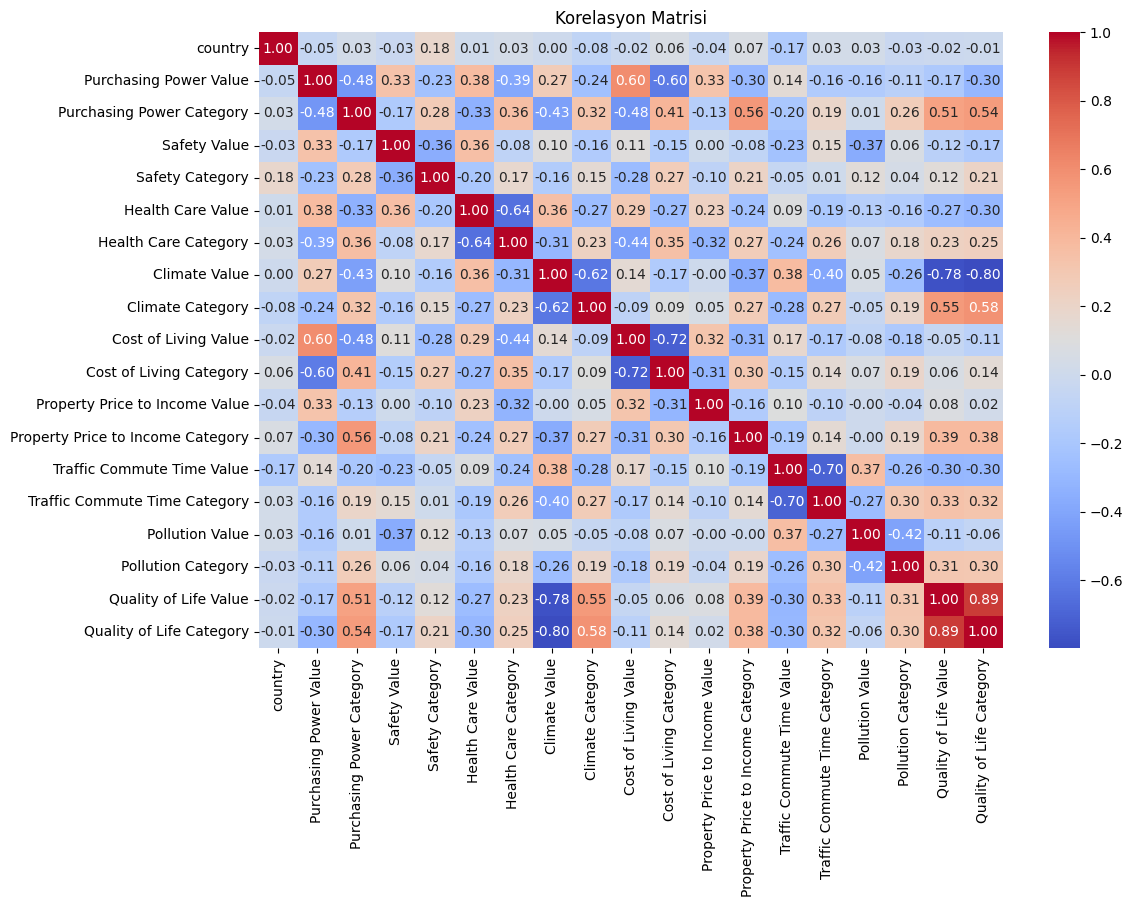

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisi
corr_matrix = df.corr()

# Isı haritası (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()




In [17]:
# Modellerin tanımlanması
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Classifier": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Model sonuçlarını saklama
results = []

# Modelleri döngü ile eğitip değerlendirme
for model_name, model in models.items():
    print(f"\nEğitiliyor: {model_name}")

    # Model eğitimi
    model.fit(X_train, y_train)

    # Tahminler
    y_pred = model.predict(X_test)

    # Olasılık veya karar fonksiyonu kontrolü
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    elif hasattr(model, "decision_function") and y_test.nunique() == 2:  # İkili sınıflandırma kontrolü
        y_proba = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = np.nan  # ROC AUC hesaplanamaz

    # Performans metrikleri
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Sonuçları kaydetme
    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": auc
    })

    # Detaylı sınıflandırma raporu
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Sonuçları DataFrame olarak görüntüleme
results_df = pd.DataFrame(results)
print("\nModel Karşılaştırma Sonuçları:")
print(results_df)



Eğitiliyor: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       1.00      0.38      0.55         8
           2       0.40      0.80      0.53         5
           3       0.70      1.00      0.82         7
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        18

    accuracy                           0.81        48
   macro avg       0.85      0.74      0.72        48
weighted avg       0.89      0.81      0.80        48


Eğitiliyor: Support Vector Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.12      0.22         8
           2       0.33      0.80      0.47         5
           3       0.64      1.00      0.78         7
           4       1.00      1.00      1.00         6
           5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       1.00      0.75      0.86         8
           2       0.57      0.80      0.67         5
           3       0.78      1.00      0.88         7
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        18

    accuracy                           0.88        48
   macro avg       0.81      0.80      0.79        48
weighted avg       0.88      0.88      0.87        48


Eğitiliyor: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         8
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        18

    accu

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


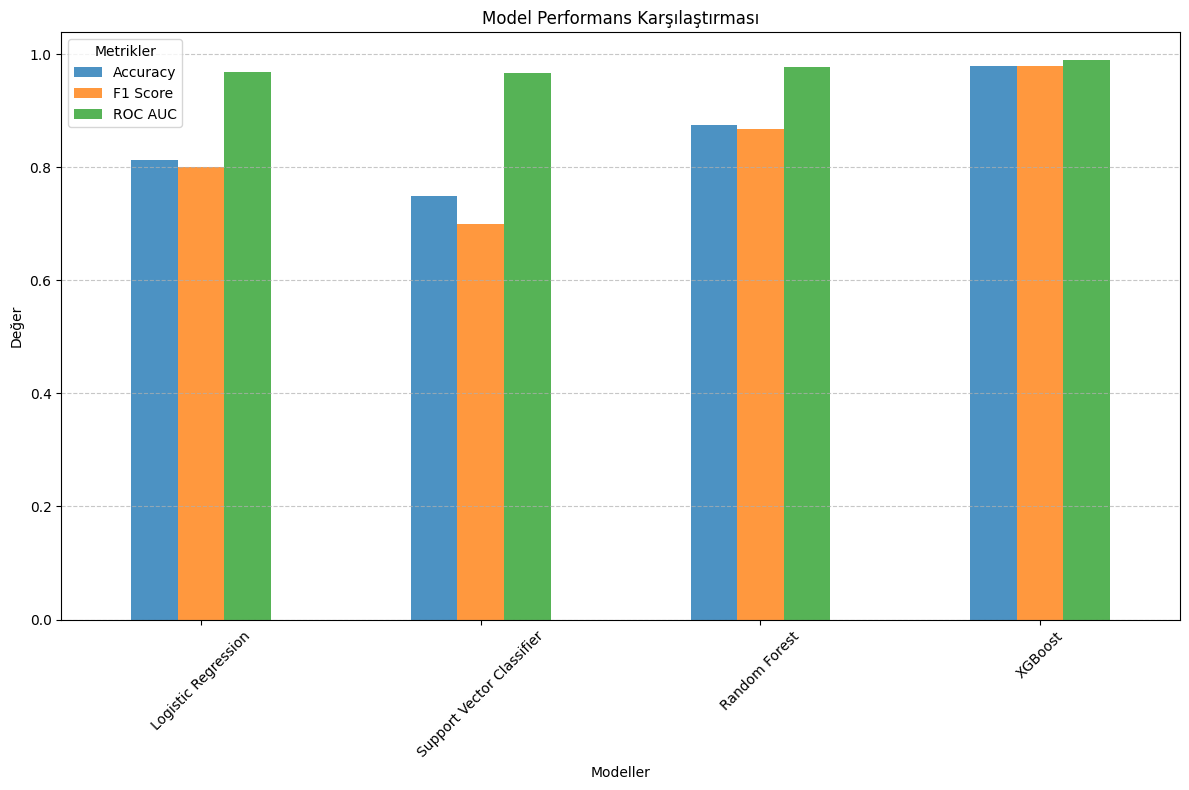

In [18]:
import matplotlib.pyplot as plt

# Grafik çizimi
results_df.set_index("Model", inplace=True)
results_df.plot(kind="bar", figsize=(12, 8), alpha=0.8)
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Değer")
plt.xlabel("Modeller")
plt.xticks(rotation=45)
plt.legend(title="Metrikler")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:
#Quality Of live value hesaplanması modellerin burdan eğitilmesi.

df = pd.read_csv(file_path)
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)
# Kategorik verileri sayısallaştırma
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Bağımsız ve bağımlı değişkenler
X = df.drop(columns=["Quality of Life Value"])  # Diğer tüm özellikler
y = df["Quality of Life Value"]  # Hedef değişken

# Eğitim ve test setine ayırma
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standartlaştırma
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Modellerin tanımlanması
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Modellerin eğitimi ve değerlendirilmesi
results = []
for model_name, model in models.items():
    # Model eğitimi
    model.fit(X_train, y_train)

    # Tahmin
    y_pred = model.predict(X_test)

    # Performans metrikleri
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Sonuçları kaydetme
    results.append({
        "Model": model_name,
        "Mean Squared Error (MSE)": mse,
        "R-squared (R2)": r2
    })

# Sonuçları DataFrame olarak gösterme
results_df = pd.DataFrame(results)
print("\nModel Performans Karşılaştırması:")
print(results_df)
results_df2= results_df.drop(columns=["Mean Squared Error (MSE)"])
results_df3 = results_df.drop(columns=["R-squared (R2)"])


Model Performans Karşılaştırması:
               Model  Mean Squared Error (MSE)  R-squared (R2)
0  Linear Regression                277.122740        0.816915
1      Random Forest                 59.892881        0.960431
2            XGBoost                112.088440        0.925947


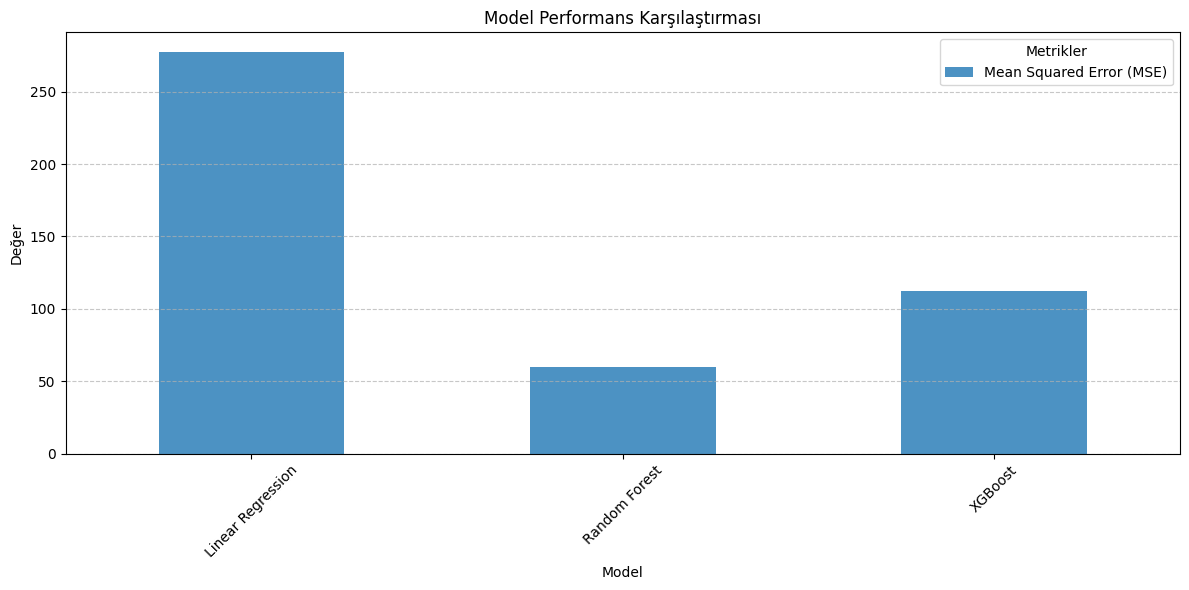

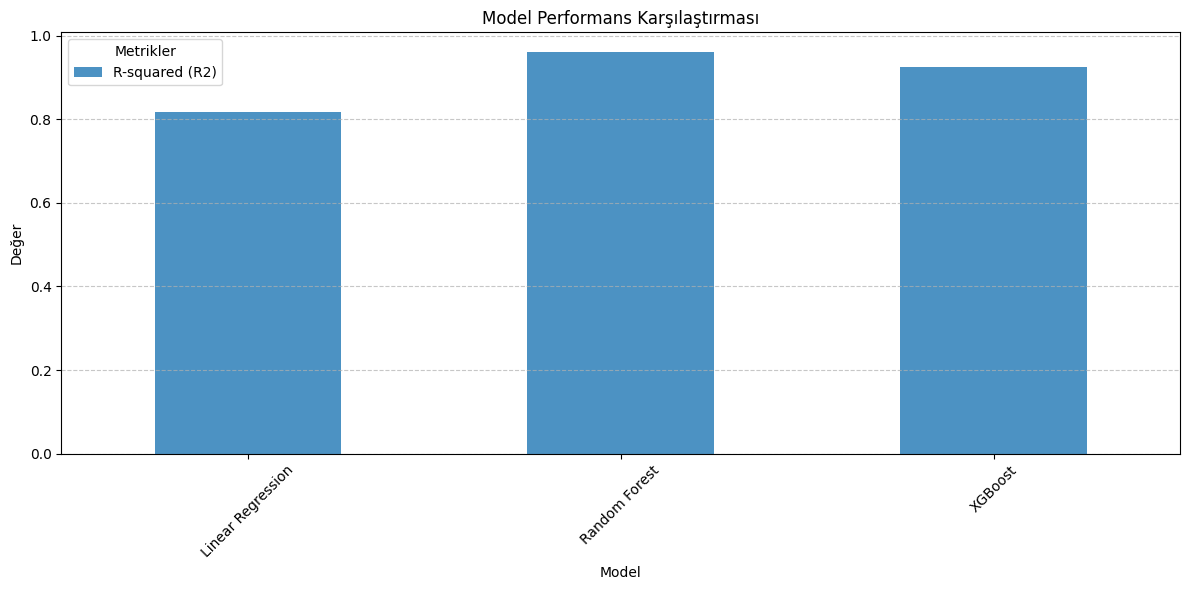

In [31]:
import matplotlib.pyplot as plt

# Grafik çizimi
results_df3.set_index("Model", inplace=True)
results_df3.plot(kind="bar", figsize=(12, 6), alpha=0.8)
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.legend(title="Metrikler")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


results_df2.set_index("Model", inplace=True)
results_df2.plot(kind="bar", figsize=(12, 6), alpha=0.8)
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.legend(title="Metrikler")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Performans değerlendirme fonksiyonu
def evaluate_regression_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("-" * 40)

    return {"Model": model_name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R-squared": r2}

# Modellerin performansını değerlendirme
results = []
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = evaluate_regression_model(y_test, y_pred, model_name)
    results.append(result)

# Sonuçları DataFrame olarak gösterme
results_df = pd.DataFrame(results)
print("\nModel Performans Karşılaştırması:")
print(results_df)


Model: Linear Regression
Mean Squared Error (MSE): 277.1227
Root Mean Squared Error (RMSE): 16.6470
Mean Absolute Error (MAE): 12.5057
R-squared (R²): 0.8169
----------------------------------------
Model: Random Forest
Mean Squared Error (MSE): 59.8929
Root Mean Squared Error (RMSE): 7.7390
Mean Absolute Error (MAE): 4.5648
R-squared (R²): 0.9604
----------------------------------------
Model: XGBoost
Mean Squared Error (MSE): 112.0884
Root Mean Squared Error (RMSE): 10.5872
Mean Absolute Error (MAE): 5.1482
R-squared (R²): 0.9259
----------------------------------------

Model Performans Karşılaştırması:
               Model         MSE       RMSE        MAE  R-squared
0  Linear Regression  277.122740  16.647004  12.505672   0.816915
1      Random Forest   59.892881   7.739049   4.564792   0.960431
2            XGBoost  112.088440  10.587183   5.148241   0.925947
